#데이터 로드 

In [7]:
!mkdir Data 
%cd ./Data 
!gdown https://drive.google.com/u/0/uc?id=1SZ5j8SJTCqQQuNHTMDHXSOMShKUvB479&export=download
!unzip open.zip 
!rm -f open.zip
%cd /content

mkdir: cannot create directory ‘Data’: File exists
/content/Data
Downloading...
From: https://drive.google.com/u/0/uc?id=1SZ5j8SJTCqQQuNHTMDHXSOMShKUvB479
To: /content/Data/open.zip
100% 2.56G/2.56G [00:28<00:00, 89.5MB/s]


In [28]:
import os 
import warnings 

import cv2 
import pandas as pd 
from glob import glob 
from tqdm import tqdm 
import random 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 

# 1단계 이미지 디렉토리 로드 

In [29]:
img_dirs = sorted(glob('./Data/train/*.jpg'))[:2000]
train_csv = pd.read_csv('./Data/train.csv')
img_size = 224 


# 2단계 이미지 데이터 로드 및 전처리 

In [ ]:

def img_preprocess(img):
    global img_size 
    img = cv2.resize(img,dsize=(img_size,img_size))
    img = img/255.
    img = img.astype(np.float16)
    return img 

def img_load(img_dir):
    img = cv2.imread(img_dir)
    img = img_preprocess(img)
    return img 

imgs = [img_load(img_dir) for img_dir in tqdm(img_dirs)]
imgs = np.array(imgs)

# 3단계 라벨 데이터 로드 

In [30]:
#라벨 데이터 정제 
label_unique = np.unique(train_csv['artist'])
label_decoder = {key:value for key,value in enumerate(label_unique)}
label_encoder = {value:key for key,value in enumerate(label_unique)}

labels = train_csv['artist'].apply(lambda x : label_encoder[x]).values[:2000]

# Train-Valid 분리 

In [42]:
valid_ratio = 0.8 
valid_index = int(len(imgs)*valid_ratio)
train_x = imgs[:valid_index]
valid_x = imgs[valid_index:]

train_y = labels[:valid_index]
valid_y = labels[valid_index:]

# 커스텀 데이터 제너레이터 

# 모델 

In [23]:
# 하이퍼 파라미터 조정 
class cfg:
    epochs = 50 
    lr = 1e-3 
    batch_size = 16 
    seed = 42 
    img_size = img_size 
#Random Seed 고정 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(2)

seed_everything(cfg.seed)      

In [18]:
from tensorflow.keras import applications 
res50 = applications.ResNet50(weights='imagenet', include_top=True, input_shape=(cfg.img_size, cfg.img_size,3)) #size -> 256, 256 
res50.trainable = True

102981632/102967424 [==============================] - 1s 0us/step


In [44]:
img_input = layers.Input(shape = (cfg.img_size,cfg.img_size,3))
x = res50(img_input)
x = layers.BatchNormalization()(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(len(label_unique),activation='softmax')(x)
model = keras.Model(img_input,out)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 batch_normalization_5 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 512)               512512    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                           

In [45]:
# mode complie 

optimizer = tf.optimizers.Adam(learning_rate = cfg.lr)
loss_fn = 'sparse_categorical_crossentropy'

In [46]:
#콜백 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):
    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()


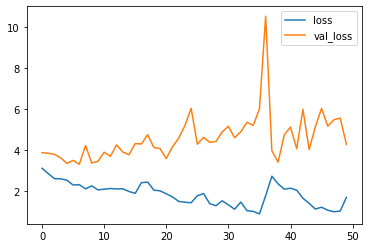

loss =  1.6822093725204468 , val_loss =  4.280880928039551
100/100 [==============================] - 19s 190ms/step - loss: 1.6822 - accuracy: 0.5131 - val_loss: 4.2809 - val_accuracy: 0.1750


In [47]:
model.compile(optimizer=optimizer,loss = loss_fn,metrics=['accuracy'])
model.fit(x = train_x, 
          y = train_y,
          batch_size = cfg.batch_size,
          epochs = cfg.epochs,
          verbose = 1,
          validation_data = [valid_x,valid_y],
          callbacks = [plot_losses],
          )
#학습한 모델 저장 
model.save('model.h5')

# Inference 

In [2]:
# 저장한 모델 로드 
model = tf.keras.models.load_model('model.h5')

In [22]:
#테스트 데이터용 제너레이터 
from tensorflow.keras.utils import Sequence
import math 
class Test_Generator(Sequence):
  def __init__(self,img_dirs,img_size,batch_size):
    self.img_dirs = img_dirs 
    self.img_size = img_size 
    self.batch_size = batch_size 

  def __len__(self):
    return math.ceil(len(self.img_dirs)/self.batch_size)
  
  def img_preprocess(self,img):
    img = cv2.resize(img,dsize=(self.img_size,self.img_size))
    img = img/255.
    img = img.astype(np.float16)
    return img 

  def img_load(self,img_dir):
    img = cv2.imread(img_dir)
    img = self.img_preprocess(img)
    return img 

  def __getitem__(self,index):
    self.batch_dirs = self.img_dirs[index*self.batch_size:(index+1)*self.batch_size]

    temp_imgs = [self.img_load(img_dir) for img_dir in self.batch_dirs]
    return np.array(temp_imgs)

In [23]:
test_dirs = sorted(glob('./Data/test/*.jpg'))
test_data = Test_Generator(test_dirs,img_size=224,batch_size=8)

In [31]:
y_ = model.predict(x=test_data)
predicted = np.argmax(y_,axis=1)

predicted_label = pd.Series(predicted).apply(lambda x : label_decoder[x]).values

In [34]:
submission = pd.read_csv('./Data/sample_submission.csv')
submission['artist'] = predicted_label
submission.to_csv('submission.csv',index=False)

# 결과 

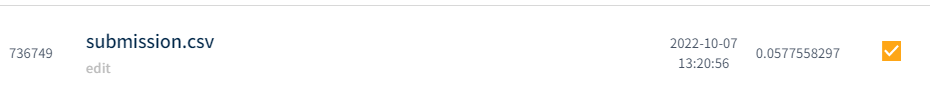